# Healthcare Graphs

## Datasets
- [Life Expectancy](https://tablebuilder.singstat.gov.sg/table/TS/M810501#!)
- [CPI](https://data.gov.sg/datasets/d_de7e93a1d0e22c790516a632747bf7f0/view?dataExplorerPage=9)

In [589]:
import pandas as pd
import requests

### Global variables 

In [590]:
BASE_DATA_GOV_URL = "https://data.gov.sg/api/action/datastore_search"
BASE_SINGSTAT_URL = "https://tablebuilder.singstat.gov.sg/api/table/tabledata"

## Retrieve data

In [591]:
# function to fetch data from data.gov.sg 
def fetch_datagov_dataset(dataset_id: str, limit: int=10_000_000) -> pd.DataFrame:
    response = requests.get(BASE_DATA_GOV_URL, params={"resource_id": dataset_id, "limit": limit})
    data = response.json()
    if not data["success"]:
        raise Error(f"Failed to fetch dataset ({dataset_id}).")
    return pd.DataFrame(data["result"]["records"])

In [592]:
def parse_singstat_2d_data(raw_data: dict) -> pd.DataFrame:
    rows = raw_data.get("Data", {}).get("row", [])
    records = []

    for row in rows:
        series_name = row.get("rowText", "")
        columns = row.get("columns", [])
        series_data = {col["key"]: col["value"] for col in columns}
        series_data["Series"] = series_name
        records.append(series_data)

    df = pd.DataFrame(records)
    df.set_index("Series")
    df.columns.name = "Year"
    return df

def fetch_singstat_dataset(dataset_id: str, limit: int = 10_000_000) -> pd.DataFrame:
    response = requests.get(
        f"{BASE_SINGSTAT_URL}/{dataset_id}",
        params={"limit": limit},
        headers={
            "Accept": "application/json",
            "User-Agent": "curl/8.11.1", # Need to fake the user agent because SingStat blocks `python-requests`.
        }
    )
    data = response.json()
    return parse_singstat_2d_data(data)

In [593]:
# fetch CPI dataset from data.gov.sg 
datagov_dataset_id = "d_de7e93a1d0e22c790516a632747bf7f0"
cpi_df = fetch_datagov_dataset(datagov_dataset_id)

sing_stat_dataset_id = "M810501"
lx_df = fetch_singstat_dataset(sing_stat_dataset_id)

## Data Exploration 

In [594]:
cpi_df.head()

,_id,DataSeries,2024Dec,2024Nov,2024Oct,2024Sep,2024Aug,2024Jul,2024Jun,2024May,...,1961Oct,1961Sep,1961Aug,1961Jul,1961Jun,1961May,1961Apr,1961Mar,1961Feb,1961Jan
0,1,All Items,117.197,116.792,116.756,117.123,116.829,116.028,116.323,116.574,...,24.463,24.393,24.517,24.276,24.223,24.053,24.187,24.585,24.565,24.542
1,2,Food,119.272,118.981,118.897,118.693,118.553,118.368,118.361,118.332,...,21.614,21.506,21.699,21.323,21.242,20.967,21.172,21.82,21.777,21.762
2,3,Food Excl Food Serving Services,118.209,117.746,117.707,117.649,117.03,116.54,116.641,116.975,...,na,na,na,na,na,na,na,na,na,na
3,4,Bread & Cereals,119.91,119.717,119.428,118.818,118.12,118.209,117.849,117.711,...,na,na,na,na,na,na,na,na,na,na
4,5,Rice,105.233,104.995,104.408,105.534,103.426,104.208,103.349,104.059,...,na,na,na,na,na,na,na,na,na,na


In [595]:
lx_df.head()

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
0,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
1,59.4,61.2,62.8,64.1,65.1,69.8,70.1,70.2,70.5,70.9,...,80.5,80.7,80.9,81.2,81.4,81.3,80.8,80.7,80.7,Male Life Expectancy At Birth (Residents)
2,63.2,65,66.6,67.8,68.8,74.7,75.2,75.3,75.7,75.8,...,85.1,85.1,85.4,85.5,85.9,85.9,85.5,85.2,85.2,Female Life Expectancy At Birth (Residents)
3,8.1,8.3,8.3,8.4,8.5,14,14.2,14.2,14.4,14.6,...,20.8,20.8,21,21.2,21.4,21.3,20.9,20.7,20.7,Total Life Expectancy At Age 65 Years (Residents)
4,7.5,7.8,7.8,8,8.2,12.6,12.7,12.8,13,13.2,...,18.9,19,19.2,19.4,19.5,19.5,19.1,19,19,Male Life Expectancy At Age 65 Years (Residents)


### Check summary statistc for dataframe

In [596]:
cpi_df.describe()

,_id
count,152.000000
mean,76.500000
std,44.022721
min,1.000000
25%,38.750000
50%,76.500000
75%,114.250000
max,152.000000


In [597]:
lx_df.describe()

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
count,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
unique,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6
top,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
freq,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


#### Check for null data

In [598]:
cpi_df.isnull().sum()

_id           0
DataSeries    0
2024Dec       0
2024Nov       0
2024Oct       0
             ..
1961May       0
1961Apr       0
1961Mar       0
1961Feb       0
1961Jan       0
Length: 770, dtype: int64

In [599]:
lx_df.isnull().sum()

Year
1957      0
1960      0
1965      0
1970      0
1975      0
1980      0
1981      0
1982      0
1983      0
1984      0
1985      0
1986      0
1987      0
1988      0
1989      0
1990      0
1991      0
1992      0
1993      0
1994      0
1995      0
1996      0
1997      0
1998      0
1999      0
2000      0
2001      0
2002      0
2003      0
2004      0
2005      0
2006      0
2007      0
2008      0
2009      0
2010      0
2011      0
2012      0
2013      0
2014      0
2015      0
2016      0
2017      0
2018      0
2019      0
2020      0
2021      0
2022      0
2023      0
Series    0
dtype: int64

#### View data types

In [600]:
cpi_df.dtypes

_id            int64
DataSeries    object
2024Dec       object
2024Nov       object
2024Oct       object
               ...  
1961May       object
1961Apr       object
1961Mar       object
1961Feb       object
1961Jan       object
Length: 770, dtype: object

In [601]:
lx_df.dtypes

Year
1957      object
1960      object
1965      object
1970      object
1975      object
1980      object
1981      object
1982      object
1983      object
1984      object
1985      object
1986      object
1987      object
1988      object
1989      object
1990      object
1991      object
1992      object
1993      object
1994      object
1995      object
1996      object
1997      object
1998      object
1999      object
2000      object
2001      object
2002      object
2003      object
2004      object
2005      object
2006      object
2007      object
2008      object
2009      object
2010      object
2011      object
2012      object
2013      object
2014      object
2015      object
2016      object
2017      object
2018      object
2019      object
2020      object
2021      object
2022      object
2023      object
Series    object
dtype: object

### Data Cleaning

#### Cleaning CPI dataset

In [602]:
cpi_df

,_id,DataSeries,2024Dec,2024Nov,2024Oct,2024Sep,2024Aug,2024Jul,2024Jun,2024May,...,1961Oct,1961Sep,1961Aug,1961Jul,1961Jun,1961May,1961Apr,1961Mar,1961Feb,1961Jan
0,1,All Items,117.197,116.792,116.756,117.123,116.829,116.028,116.323,116.574,...,24.463,24.393,24.517,24.276,24.223,24.053,24.187,24.585,24.565,24.542
1,2,Food,119.272,118.981,118.897,118.693,118.553,118.368,118.361,118.332,...,21.614,21.506,21.699,21.323,21.242,20.967,21.172,21.82,21.777,21.762
2,3,Food Excl Food Serving Services,118.209,117.746,117.707,117.649,117.03,116.54,116.641,116.975,...,na,na,na,na,na,na,na,na,na,na
3,4,Bread & Cereals,119.91,119.717,119.428,118.818,118.12,118.209,117.849,117.711,...,na,na,na,na,na,na,na,na,na,na
4,5,Rice,105.233,104.995,104.408,105.534,103.426,104.208,103.349,104.059,...,na,na,na,na,na,na,na,na,na,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,148,Other Personal Effects,94.905,94.709,98.382,97.186,98.057,97.618,97.948,100.576,...,na,na,na,na,na,na,na,na,na,na
148,149,Social Services,94.99,94.99,94.99,94.611,94.611,94.611,94.211,94.211,...,na,na,na,na,na,na,na,na,na,na
149,150,Other Miscellaneous Services,97.175,97.115,97.055,97.276,96.173,95.58,95.009,95.035,...,na,na,na,na,na,na,na,na,na,na
150,151,All Items Less Imputed Rentals On Owner-Occupi...,117.46,116.985,116.96,117.43,117.101,116.166,116.573,116.918,...,na,na,na,na,na,na,na,na,na,na


In [603]:
# remove all rows except healthcare in CPI data
index_to_keep = cpi_df.index[cpi_df['DataSeries'].str.contains("Health Care")][0]
cpi_df = cpi_df.drop(cpi_df.index[cpi_df.index != index_to_keep])

In [604]:
def get_yearly_avg(cpi_df: pd.DataFrame, y_range: int = 11) -> pd.DataFrame:
    current_year = 2023
    year_range = [str(current_year-x) for x in range(y_range)]

    yearly_avg = {}
    for year in year_range:
        month_col = [col for col in cpi_df.columns if col.startswith(year)]

        if month_col: 
            cpi_df[month_col] = cpi_df[month_col].apply(pd.to_numeric)
            yearly_avg[year] = cpi_df[month_col].sum(axis=1) / len(month_col)
            
    return pd.DataFrame(yearly_avg)


In [605]:
# merge all monthly average to yearly average 
hc_yearly_df = get_yearly_avg(cpi_df)
hc_yearly_df

,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
82,106.321417,101.746167,99.57925,98.463417,99.999917,98.90525,96.924333,94.566083,93.560417,93.6395,91.116833


#### Clean Life Expectancy data

In [606]:
lx_df

Year,1957,1960,1965,1970,1975,1980,1981,1982,1983,1984,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,Series
0,61.1,62.9,64.5,65.8,66.8,72.1,72.5,72.6,73,73.3,...,82.9,83,83.2,83.4,83.7,83.7,83.2,83,83,Total Life Expectancy At Birth (Residents)
1,59.4,61.2,62.8,64.1,65.1,69.8,70.1,70.2,70.5,70.9,...,80.5,80.7,80.9,81.2,81.4,81.3,80.8,80.7,80.7,Male Life Expectancy At Birth (Residents)
2,63.2,65,66.6,67.8,68.8,74.7,75.2,75.3,75.7,75.8,...,85.1,85.1,85.4,85.5,85.9,85.9,85.5,85.2,85.2,Female Life Expectancy At Birth (Residents)
3,8.1,8.3,8.3,8.4,8.5,14,14.2,14.2,14.4,14.6,...,20.8,20.8,21,21.2,21.4,21.3,20.9,20.7,20.7,Total Life Expectancy At Age 65 Years (Residents)
4,7.5,7.8,7.8,8,8.2,12.6,12.7,12.8,13,13.2,...,18.9,19,19.2,19.4,19.5,19.5,19.1,19,19,Male Life Expectancy At Age 65 Years (Residents)
5,8.6,8.8,8.8,8.9,8.9,15.4,15.6,15.6,15.8,15.9,...,22.3,22.4,22.6,22.7,23,23,22.6,22.3,22.2,Female Life Expectancy At Age 65 Years (Reside...


In [607]:
series_name = "Total Life Expectancy At Birth (Residents)"

lx_yearly_df = lx_df[lx_df["Series"] == series_name].drop(columns=["Series"])

years_to_use = [str(2023-x) for x in range(11)]

lx_yearly_df = lx_yearly_df[years_to_use]

lx_yearly_df

Year,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
0,83,83,83.2,83.7,83.7,83.4,83.2,83,82.9,82.6,82.4


### Combine the dataframe

In [608]:
lx_yearly_df = lx_yearly_df.drop(columns=["level_0", "index"], errors="ignore")
lx_yearly_df = lx_yearly_df.reset_index(drop=True)

merged_df = pd.concat([lx_yearly_df, hc_yearly_df])
merged_df.reset_index()
merged_df.index = ["Life Expectancy", "Healthcare Average"]
merged_df

,2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013
Life Expectancy,83,83,83.2,83.7,83.7,83.4,83.2,83,82.9,82.6,82.4
Healthcare Average,106.321417,101.746167,99.57925,98.463417,99.999917,98.90525,96.924333,94.566083,93.560417,93.6395,91.116833


## Graph

In [609]:
import seaborn as sns
import matplotlib.pyplot as plt

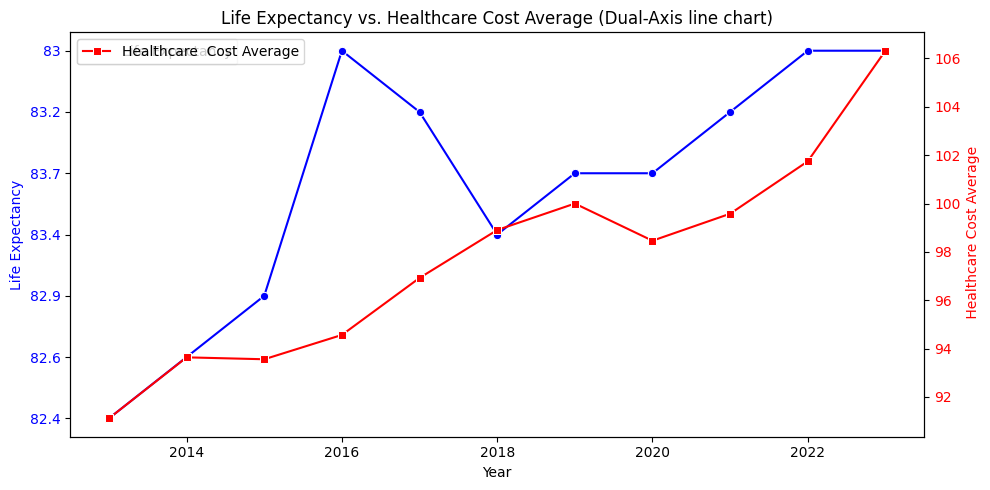

In [610]:
merged_df = merged_df.T.reset_index().rename(columns={"index": "Year"})
merged_df["Year"] = merged_df["Year"].astype(int)
merged_df

fig, ax1 = plt.subplots(figsize=(10, 5))
# first line 
sns.lineplot(data=merged_df, x="Year", y="Life Expectancy", marker="o", ax=ax1, color="blue", label="Life Expectancy")  
ax1.set_ylabel("Life Expectancy", color="blue")
ax1.tick_params(axis='y', labelcolor="blue")

# second line
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x="Year", y="Healthcare Average", marker='s', ax=ax2, color="red", label="Healthcare  Cost Average")
ax2.set_ylabel(" Healthcare Cost Average", color="red")
ax2.tick_params(axis='y', labelcolor="red")

# title 
ax1.set_xlabel("Year")
ax1.set_title("Life Expectancy vs. Healthcare Cost Average (Dual-Axis line chart)")
fig.tight_layout()

plt.show()